In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import pandas as pd

%matplotlib inline

import tensorflow as tf

from tf_agents import agents
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from OSAR import OSARNetwork, Runner, DQNTrialAgent
from obstacle_tower_env import ObstacleTowerEnv

print(tf.version.VERSION)

2.7.0


2021-11-21 16:28:21.899464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 16:28:21.951816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 16:28:21.952184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 16:28:21.954299: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## Launching the environment (retro mode)

Launching Obstacle Tower ```retro mode``` which uses observation and action spaces similar to those found in the Arcade Learning Environment (ALE).

In [3]:
# Realtime mode determines whether the environment window will render the scene,
# as well as whether the environment will run at realtime speed. Set this to `True`
# to visual the agent behavior as you would in player mode.

env = ObstacleTowerEnv(retro=True, realtime_mode=True, worker_id=666)

Found path: /tmp/ml-agents-binaries/binaries/ObstacleTower-3ab155c962d77775bc1e66b866180213/ObstacleTower/obstacletower.x86_64


INFO:mlagents_envs.environment:Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0
INFO:mlagents_envs.environment:Connected new brain:
ObstacleTowerAgent-v4.1?team=0
INFO:gym_unity:1 agents within environment.


In [4]:
# The environment provided has a MultiDiscrete action space, where the 4 dimensions are:

# 0. Movement (No-Op/Forward/Back)
# 1. Camera Rotation (No-Op/Counter-Clockwise/Clockwise)
# 2. Jump (No-Op/Jump)
# 3. Movement (No-Op/Right/Left)

env.action_space

Discrete(54)

In [5]:
# The observation space provided includes a 168x168 image (the camera from the simulation)
# as well as the number of keys held by the agent (0-5) and the amount of time remaining.
# In retro mode, the observation is an 84x84 image with the time remaining and key count visually embedded.
print(env.observation_space)

Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
 

## Interacting with the environment

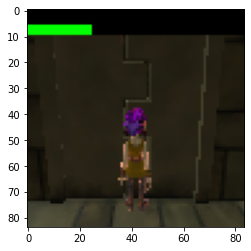

In [6]:
obs = env.reset()
plt.imshow(obs)

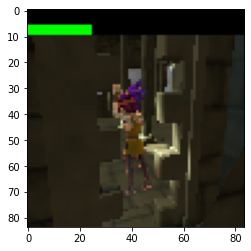

In [7]:
obs, reward, done, info = env.step(env.action_space.sample())
plt.imshow(obs)

## Closing the environment

In [15]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

## Setting environment parameters

In [9]:
env_names = [
    {'env': ObstacleTowerEnv,
     'name': 'OTC',
     'settings':{'retro': True, 'realtime_mode': False}},
]

In [10]:
num_iterations = 1 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 1000  # @param {type:"integer"}

batch_size = 1  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 20  # @param {type:"integer"}
memory_len = 10 # @param {type: "integer"}
n_turns = 3 # @param {type: "integer"}
num_atoms = 51  # @param {type:"integer"}
q_value = 10  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 20  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

boltzmann_temperature = 10e-5 # @param {type:"float"}
epsilon_greedy = None # @param {type:"float"}
conv_type = '2d' # @param {type:"str"}

In [11]:
fc_layer_params = (64, 64)
from tf_agents.networks import categorical_q_network, q_network

osar_specs = {
    'batch_size': batch_size,
    'memory_len': memory_len,
    'n_turns': n_turns,
    'fc_layer_params': fc_layer_params,
    'num_atoms': num_atoms,
    'conv_type': conv_type,
    'learning_rate': learning_rate,
    'q_value': q_value,
    'n_step_update': n_step_update,
    'boltzmann_temperature': boltzmann_temperature,
    'epsilon_greedy': epsilon_greedy,
    'debug_summaries': True,
    'summarize_grads_and_vars': True,
}

def osar_generator(
    observation_spec,
    action_spec,
    batch_size,
    memory_len,
    n_turns,
    fc_layer_params,
    num_atoms,
    conv_type,
    learning_rate,
    time_step_spec,
    n_step_update,
    train_step_counter,
    q_value=q_value,
    boltzmann_temperature=None,
    epsilon_greedy=0.1,
    debug_summaries=True,
    summarize_grads_and_vars=True,
    **kwargs,
    ):
    q_net = OSARNetwork(
        observation_spec,
        action_spec,
        batch_size,
        memory_len,
        n_turns,
        fc_layer_params=fc_layer_params,
        conv_type=conv_type,
        )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    agent = DQNTrialAgent(
        time_step_spec,
        action_spec,
        network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        boltzmann_temperature=boltzmann_temperature,
        epsilon_greedy=epsilon_greedy,
        debug_summaries=debug_summaries,
        train_step_counter = tf.Variable(0, dtype=tf.int64),
        summarize_grads_and_vars=summarize_grads_and_vars,
    )
    
    agent.initialize()
    
    return agent

    

In [12]:
experiment_common_specs = {
    'agent_specs': osar_specs,
    'agent_generator': osar_generator,
    'num_iterations': num_iterations,
    'initial_collect_steps': initial_collect_steps,
    'collect_steps_per_iteration': collect_steps_per_iteration,
    'replay_buffer_max_length': replay_buffer_max_length,
    'num_eval_episodes': num_eval_episodes,
    'eval_interval': eval_interval,
    'n_step_update': n_step_update,
}

In [13]:
configs = []
for name in env_names:
    config = experiment_common_specs.copy()
    config['env_name'] = name
    configs.append(config)

In [14]:
%%time
logpath = ''
model_name = 'OTC_osar'
runner = Runner(model_name=model_name, logpath=logpath, list_configs=configs)
runner.run(progress=False, experiment_progress=True)

Found path: /tmp/ml-agents-binaries/binaries/ObstacleTower-3ab155c962d77775bc1e66b866180213/ObstacleTower/obstacletower.x86_64


INFO:mlagents_envs.environment:Environment timed out shutting down. Killing...


UnityTimeOutException: The Unity environment took too long to respond. Make sure that :
	 The environment does not need user interaction to launch
	 The Agents' Behavior Parameters > Behavior Type is set to "Default"
	 The environment and the Python interface have compatible versions.
  In call to configurable 'Experiment' (<class 'OSAR.runner.Experiment'>)

In [ ]:
fc_layer_params = (64, 64)
from tf_agents.networks import categorical_q_network, q_network

c51_specs = {
    'batch_size': batch_size,
    'memory_len': memory_len,
    'n_turns': n_turns,
    'fc_layer_params': fc_layer_params,
    'num_atoms': num_atoms,
    'conv_type': conv_type,
    'learning_rate': learning_rate,
    'q_value': q_value,
    'n_step_update': n_step_update,
    'boltzmann_temperature': boltzmann_temperature,
    'epsilon_greedy': epsilon_greedy,
    'debug_summaries': True,
    'summarize_grads_and_vars': True,
}
def c51_generator(
    observation_spec,
    action_spec,
    batch_size,
    memory_len,
    n_turns,
    fc_layer_params,
    num_atoms,
    learning_rate,
    time_step_spec,
    n_step_update,
    conv_type,
    train_step_counter,
    q_value=q_value,
    boltzmann_temperature=None,
    epsilon_greedy=0.1,
    debug_summaries=True,
    summarize_grads_and_vars=True,
    ):

    q_net = categorical_q_network.CategoricalQNetwork(
    observation_spec,
    action_spec,
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    n_step_update = 1
    
    agent = agents.categorical_dqn.categorical_dqn_agent.CategoricalDqnAgent(
        time_step_spec,
        action_spec,
        categorical_q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter = tf.Variable(0, dtype=tf.int64),
        min_q_value = -q_value,
        max_q_value = q_value,
        n_step_update = n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        epsilon_greedy=epsilon_greedy,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
    )
    agent.initialize()
    
    return agent

experiment_c51_specs = {
    'agent_specs': c51_specs,
    'agent_generator': c51_generator,
    'num_iterations': num_iterations,
    'initial_collect_steps': initial_collect_steps,
    'collect_steps_per_iteration': collect_steps_per_iteration,
    'replay_buffer_max_length': replay_buffer_max_length,
    'num_eval_episodes': num_eval_episodes,
    'eval_interval': eval_interval,
    'n_step_update': n_step_update,
}
configs = []
for name in env_names:
    config = experiment_c51_specs.copy()
    config['env_name'] = name
    configs.append(config)

In [ ]:
%%time
logpath = ''
model_name = 'OTC_c51'
runner = Runner(model_name=model_name, logpath=logpath, list_configs=configs)
runner.run(progress=False, experiment_progress=True)

In [ ]:
fc_layer_params = (64, 64)
from tf_agents.networks import categorical_q_network, q_network

dqn_specs = {
    'batch_size': batch_size,
    'memory_len': memory_len,
    'n_turns': n_turns,
    'fc_layer_params': fc_layer_params,
    'num_atoms': num_atoms,
    'conv_type': conv_type,
    'learning_rate': learning_rate,
    'q_value': q_value,
    'n_step_update': n_step_update,
    'boltzmann_temperature': boltzmann_temperature,
    'epsilon_greedy': epsilon_greedy,
    'debug_summaries': True,
    'summarize_grads_and_vars': True,
}

def dqn_generator(
    observation_spec,
    action_spec,
    batch_size,
    memory_len,
    n_turns,
    fc_layer_params,
    num_atoms,
    conv_type,
    learning_rate,
    time_step_spec,
    n_step_update,
    train_step_counter,
    q_value=10,
    boltzmann_temperature=None,
    epsilon_greedy=0.1,
    debug_summaries=True,
    summarize_grads_and_vars=True,
    ):

    q_net = q_network.QNetwork(
        observation_spec,
        action_spec,
        fc_layer_params=fc_layer_params)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    n_step_update = 1
    
    agent = agents.dqn.dqn_agent.DqnAgent(
        time_step_spec,
        action_spec,
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter = tf.Variable(0, dtype=tf.int64),
        n_step_update = n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        epsilon_greedy=epsilon_greedy,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
    )
    agent.initialize()
    
    return agent

experiment_dqn_specs = {
    'agent_specs': dqn_specs,
    'agent_generator': dqn_generator,
    'num_iterations': num_iterations,
    'initial_collect_steps': initial_collect_steps,
    'collect_steps_per_iteration': collect_steps_per_iteration,
    'replay_buffer_max_length': replay_buffer_max_length,
    'num_eval_episodes': num_eval_episodes,
    'eval_interval': eval_interval,
    'n_step_update': n_step_update,
}
configs = []
for name in env_names:
    config = experiment_dqn_specs.copy()
    config['env_name'] = name
    configs.append(config)

In [ ]:
%%time
logpath = ''
model_name = 'OTC_dqn'
runner = Runner(model_name=model_name, logpath=logpath, list_configs=configs)
runner.run(progress=False, experiment_progress=True)

In [ ]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs

In [ ]:
# !kill 1369

In [ ]:
dqn_reward = pd.read_csv('logs/OTC_dqn/datasets/Alien-ram-v0-steps.csv').loc[:, 'Uclipped Return Train'].values.cumsum()
osar_reward = pd.read_csv('logs/OTC_osar/datasets/Alien-ram-v0-steps.csv').loc[:, 'Uclipped Return Train'].values.cumsum()
c51_reward = pd.read_csv('logs/OTC_c51/datasets/Alien-ram-v0-steps.csv').loc[:, 'Uclipped Return Train'].values.cumsum()

plt.figure(figsize=(7, 8))
plt.xlabel = 'Episode'
plt.ylabel = 'Unclipped Summary Reward'
plt.plot(dqn_reward, 'r', label='DQN')
plt.plot(c51_reward, 'b', label='C51')
plt.plot(osar_reward, 'k', label='OSAR')
plt.grid()
plt.legend()
plt.savefig('logs/cum_reward_otc.png')
plt.show()